In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta
import sys
from datetime import datetime

M0 = 1480 #mT
shape = [5*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, options={'maxiter':100000}, *args
    ) 
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res.x 

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Time Passed (s)')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Time Passed (s)')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# Function to convert HHMMSS to seconds
def time_to_seconds(time_str):
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    return hours * 3600 + minutes * 60 + seconds

def time_to_secondsdf(time_value):
    return time_value.hour * 3600 + time_value.minute * 60 + time_value.second + time_value.microsecond / 1e6

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path (without the extension)
    filename = os.path.basename(file_path).replace('.npz', '')
    
    # Split the filename into date, time, and millisecond parts
    date_part = filename.split('-')[0]  # Extracting the 'YYYYMMDD' part
    time_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    millisecond_part = filename.split('-')[2]  # Extracting the millisecond part
    
    # Combine date, time, and milliseconds into a full timestamp string
    full_datetime_str = f"{date_part} {time_part}.{millisecond_part}"
    
    # Create a datetime object
    full_datetime = datetime.strptime(full_datetime_str, "%Y%m%d %H%M%S.%f")
    
    return full_datetime

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    timestamps = []

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        timestamps.append(extract_timestamp(file_list[x]))

        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev, timestamps

def importdata(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    B = [np.array(pos)]
    timestamps = []

    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        mags = np.mean(mags, axis=0)
        
        B = np.append(B, [mags], axis=0)
        timestamps.append(extract_timestamp(file_list[x]))  
    B = np.delete(B, 0, axis=0)

    return B, timestamps

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

def sensorplots(B, timestamps,sensor):
    mag = [np.array([0, 0, 0])]
    for x in range(len(B)):
        mag = np.append(mag, [B[x][sensor]], axis=0)
    mag = np.delete(mag, 0, axis=0)

    measuredbx = go.Scatter(x=timestamps, y=mag[:,0], mode='markers')
    layoutbx = go.Layout(title='b_x over time, sensor ' + str(sensor))
    figbx = go.Figure(data=[measuredbx], layout=layoutbx)
    figbx.update_yaxes(scaleanchor='y')
    figbx.update_layout(
        xaxis_title="Time",
        yaxis_title="b_x [mT]"
    )
    figbx.show()

    measuredby = go.Scatter(x=timestamps, y=mag[:,1], mode='markers')
    layoutby = go.Layout(title='b_y over time sensor ' + str(sensor))
    figby = go.Figure(data=[measuredby], layout=layoutby)
    figby.update_yaxes(scaleanchor='y')
    figby.update_layout(
        xaxis_title="Time",
        yaxis_title="b_y [mT]"
    )
    figby.show()

    measuredbz = go.Scatter(x=timestamps, y=mag[:,2], mode='markers')
    layoutbz = go.Layout(title='b_z over time sensor ' + str(sensor))
    figbz = go.Figure(data=[measuredbz], layout=layoutbz)
    figbz.update_yaxes(scaleanchor='y')
    figbz.update_layout(
        xaxis_title="Time",
        yaxis_title="b_z [mT]"
    )
    figbz.show()

In [140]:
folder = os.path.join('..', './MLX12132024_D52N52_gk')
B, timestamps = importdata(folder)

In [141]:
sensorplots(B, timestamps, 6)

import functions from MagneticSensorTracking
graph bx, by, bz for all 16 sensors
try averaging the sensors logs
try restarting pi to see if time error is from restarts
fix the mount

In [142]:
pos, mags, locpred, anglepred, Bstdev, timestamps = importfitting(folder)
np.append(locpred, anglepred, axis=1)
#print(timeelapsed)
print(len(locpred))

9


In [143]:
timestamps
# Define the incorrect and correct timestamps
incorrect_time = pd.to_datetime("2024-12-11 06:26:38")  # Incorrect datetime
correct_time = pd.to_datetime("2024-12-13 16:40:00")    # Correct datetime

# Calculate the time difference
time_difference = correct_time - incorrect_time

# Apply the time difference to correct the timestamps
corrected_timestamps = [t + time_difference for t in timestamps]

# Print the results
print("Original Timestamps:")
print(timestamps)
print("\nCorrected Timestamps:")
print(corrected_timestamps)

Original Timestamps:
[datetime.datetime(2024, 12, 11, 6, 26, 12, 448489), datetime.datetime(2024, 12, 11, 6, 26, 38, 182827), datetime.datetime(2024, 12, 11, 6, 26, 47, 612112), datetime.datetime(2024, 12, 11, 6, 26, 59, 644345), datetime.datetime(2024, 12, 11, 6, 27, 12, 966368), datetime.datetime(2024, 12, 11, 6, 27, 33, 579053), datetime.datetime(2024, 12, 11, 6, 28, 12, 800105), datetime.datetime(2024, 12, 11, 6, 28, 34, 471110), datetime.datetime(2024, 12, 11, 6, 28, 45, 546328)]

Corrected Timestamps:
[datetime.datetime(2024, 12, 13, 16, 39, 34, 448489), datetime.datetime(2024, 12, 13, 16, 40, 0, 182827), datetime.datetime(2024, 12, 13, 16, 40, 9, 612112), datetime.datetime(2024, 12, 13, 16, 40, 21, 644345), datetime.datetime(2024, 12, 13, 16, 40, 34, 966368), datetime.datetime(2024, 12, 13, 16, 40, 55, 579053), datetime.datetime(2024, 12, 13, 16, 41, 34, 800105), datetime.datetime(2024, 12, 13, 16, 41, 56, 471110), datetime.datetime(2024, 12, 13, 16, 42, 7, 546328)]


In [144]:
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

all_mags = [np.array([0,0,0])]
for x in range(len(file_list)):
    try:
        data = np.load(file_list[x])
    except:
        display(file_list[x])
    mags = data['mags']
    all_mags = np.append(all_mags, mags[0], axis=0)
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
all_mags = np.delete(all_mags, 0, axis=0)

bx = all_mags[:,0]
by = all_mags[:,1]
bz = all_mags[:,2]

In [145]:
bx7 = []
by7 = []
bz7 = []
for x in range(len(bx)):
    if x % 16 == 7:
        bx7.append(bx[x])
        by7.append(by[x])
        bz7.append(bz[x])
print(bx7)
print(by7)
print(bz7)
print(pos)

[-0.192, -0.159, -0.1884, -0.2109, -0.1881, -0.22829999999999998, -0.1689, -0.198, -0.2637]
[-0.0762, -0.0762, -0.078, -0.078, -0.08220000000000001, -0.05669999999999999, -0.0495, -0.063, -0.062099999999999995]
[-0.72842, -0.69212, -0.7264839999999999, -0.7535879999999999, -0.729388, -0.709544, -0.666952, -0.712448, -0.7860159999999999]
[[ 6.75 -6.75  0.  ]
 [ 2.25 -6.75  0.  ]
 [-2.25 -6.75  0.  ]
 [-6.75 -6.75  0.  ]
 [ 6.75 -2.25  0.  ]
 [ 2.25 -2.25  0.  ]
 [-2.25 -2.25  0.  ]
 [-6.75 -2.25  0.  ]
 [ 6.75  2.25  0.  ]
 [ 2.25  2.25  0.  ]
 [-2.25  2.25  0.  ]
 [-6.75  2.25  0.  ]
 [ 6.75  6.75  0.  ]
 [ 2.25  6.75  0.  ]
 [-2.25  6.75  0.  ]
 [-6.75  6.75  0.  ]]


In [146]:
index = np.array(range(len(bx7)))
measuredbx = go.Scatter(x=timestamps, y=bx7, mode='markers')
layoutbx = go.Layout(title='b_x over time')
figbx = go.Figure(data=[measuredbx], layout=layoutbx)
figbx.update_yaxes(scaleanchor='y')
figbx.update_layout(
    xaxis_title="Time",
    yaxis_title="b_x [mT]"
)
figbx.show()

In [147]:
measuredby = go.Scatter(x=corrected_timestamps, y=by7, mode='markers')
layoutby = go.Layout(title='b_y over time')
figby = go.Figure(data=[measuredby], layout=layoutby)
figby.update_yaxes(scaleanchor='y')
figby.update_layout(
    xaxis_title="Time",
    yaxis_title="b_y [mT]"
)
figby.show()

In [148]:
measuredbz = go.Scatter(x=corrected_timestamps, y=bz7, mode='markers')
layoutbz = go.Layout(title='b_z over time')
figbz = go.Figure(data=[measuredbz], layout=layoutbz)
figbz.update_yaxes(scaleanchor='y')
figbz.update_layout(
    xaxis_title="Time",
    yaxis_title="b_z [mT]"
)
figbz.show()

In [149]:
# Specify the Excel file name (replace with your actual file name)
file = 'Shift_data_12112024.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df[['X', 'Y', 'Z', 'Displacement [mm]']] = df[['X', 'Y', 'Z', 'Displacement [mm]']].apply(pd.to_numeric,errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S.%f')
df['datetime'] = df.loc[0:,'Time'].dt.time


print(df)
hdmm_time = df['Time']
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_time)

                        Time     X      Y      Z  Displacement [mm]  \
4    2024-12-13 16:35:12.236  0.00   0.00   0.00               0.00   
5    2024-12-13 16:35:12.751 -0.01  -0.00   0.00               0.01   
6    2024-12-13 16:35:13.269 -0.01   0.01   0.04               0.04   
7    2024-12-13 16:35:13.816  0.01   0.01   0.02               0.02   
8    2024-12-13 16:35:14.331 -0.00   0.01  -0.03               0.03   
...                      ...   ...    ...    ...                ...   
4797 2024-12-13 17:16:44.799 -6.57 -58.29 -18.31               0.02   
4798 2024-12-13 17:16:45.299 -6.56 -58.30 -18.31               0.02   
4799 2024-12-13 17:16:45.812 -6.55 -58.30 -18.31               0.02   
4800 2024-12-13 17:16:46.332 -6.56 -58.31 -18.34               0.02   
4801 2024-12-13 17:16:46.877 -6.55 -58.29 -18.31               0.02   

             datetime  
4     16:35:12.236000  
5     16:35:12.751000  
6     16:35:13.269000  
7     16:35:13.816000  
8     16:35:14.331000  
...

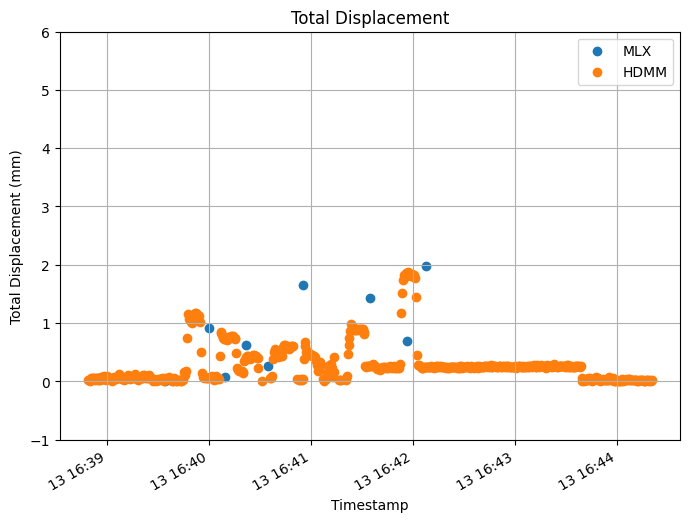

In [150]:
rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, disp, label='MLX')
plt.scatter(hdmm_time[400:1000], hdmm_disp[400:1000], label='HDMM')
#plt.scatter(hdmm_time[a:b], hdmm_disp2)
# Set x-axis labels to show only the time
# Format the x-axis to show date and time properly
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Total Displacement (mm)')
plt.ylim(-1, 6)
plt.title('Total Displacement')
plt.legend()
plt.grid(True)
plt.show()

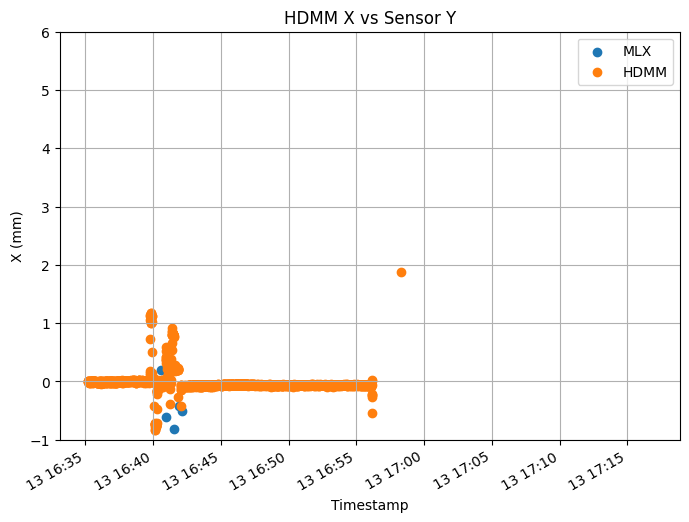

In [151]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, rel_loc_predy, label='MLX')
plt.scatter(hdmm_time, hdmm_x, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('X (mm)')
plt.ylim([-1,6])
plt.title('HDMM X vs Sensor Y')
plt.grid(True)
plt.legend()
plt.show()

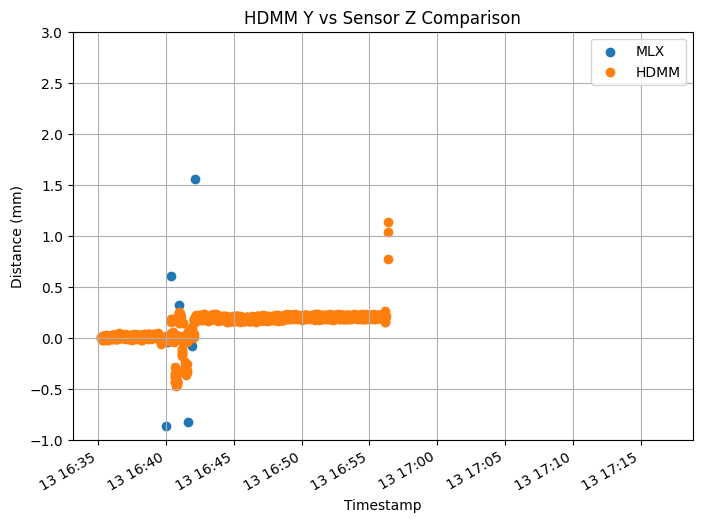

In [152]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, -np.array(rel_loc_predz), label='MLX')
plt.scatter(hdmm_time, hdmm_y, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Distance (mm)')
plt.ylim(-1,3)
plt.title('HDMM Y vs Sensor Z Comparison')
plt.grid(True)
plt.legend()
plt.show()

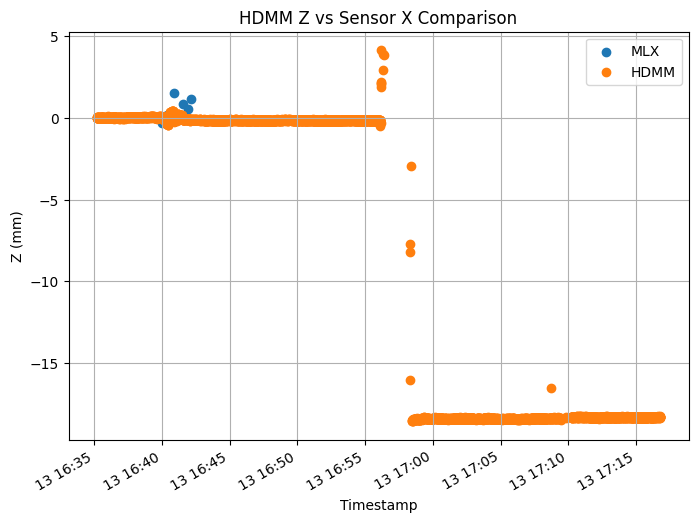

In [153]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(corrected_timestamps, rel_loc_predx, label='MLX')
plt.scatter(hdmm_time, hdmm_z, label='HDMM')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Z (mm)')
plt.title('HDMM Z vs Sensor X Comparison')
plt.grid(True)
plt.legend()
plt.show()